# ToolNode 를 사용하여 도구를 호출하는 방법

이번 튜토리얼에서는 도구 호출을 위한 LangGraph의 사전 구축된 `pre-built`의 `ToolNode` 사용 방법을 다룹니다.

`ToolNode`는 메시지 목록이 포함된 그래프 상태를 입력으로 받아 도구 호출 결과로 상태를 업데이트하는 LangChain Runnable입니다. 

이는 LangGraph의 사전 구축된 Agent 와 즉시 사용할 수 있도록 설계되었으며, 상태에 적절한 리듀서가 있는 `messages` 키가 포함된 경우 모든 `StateGraph` 와 함께 작동할 수 있습니다.

In [1]:
# API 키를 환경변수로 관리하기 위한 설정 파일
from dotenv import load_dotenv

# API 키 정보 로드
load_dotenv()

True

In [2]:
# LangSmith 추적을 설정합니다. https://smith.langchain.com
# !pip install -qU langchain-teddynote
from langchain_teddynote import logging

# 프로젝트 이름을 입력합니다.
logging.langsmith("CH17-LangGraph-Modules")

LangSmith 추적을 시작합니다.
[프로젝트명]
CH17-LangGraph-Modules


## 도구 정의

먼저, 도구를 정의해보겠습니다.

In [3]:
from langchain_core.tools import tool
from langchain_experimental.tools.python.tool import PythonAstREPLTool
from langchain_teddynote.tools import GoogleNews
from typing import List, Dict


# 도구 생성
@tool
def search_news(query: str) -> List[Dict[str, str]]:
    """Search Google News by input keyword"""
    news_tool = GoogleNews()
    return news_tool.search_by_keyword(query, k=5)


@tool
def python_code_interpreter(code: str):
    """Call to execute python code."""
    return PythonAstREPLTool().invoke(code)

다음으로는 `ToolNode` 를 사용하여 도구를 호출하는 방법을 살펴보겠습니다.

In [4]:
from langgraph.prebuilt import ToolNode, tools_condition

# 도구 리스트 생성
tools = [search_news, python_code_interpreter]

# ToolNode 초기화
tool_node = ToolNode(tools)

## `ToolNode`를 수동으로 호출하기

`ToolNode`는 메시지 목록과 함께 그래프 상태에서 작동합니다. 

- **중요**: 이때 목록의 마지막 메시지는 `tool_calls` 속성을 포함하는 `AIMessage`여야 합니다.

먼저 도구 노드를 수동으로 호출하는 방법을 살펴보겠습니다.

In [5]:
from langchain_core.messages import AIMessage

# 단일 도구 호출을 포함하는 AI 메시지 객체 생성
# AIMessage 객체이어야 함
message_with_single_tool_call = AIMessage(
    content="",
    tool_calls=[
        {
            "name": "search_news",  # 도구 이름
            "args": {"query": "AI"},  # 도구 인자
            "id": "tool_call_id",  # 도구 호출 ID
            "type": "tool_call",  # 도구 호출 유형
        }
    ],
)

# 도구 노드를 통한 메시지 처리 및 날씨 정보 요청 실행
tool_node.invoke({"messages": [message_with_single_tool_call]})

{'messages': [ToolMessage(content='[{"url": "https://news.google.com/rss/articles/CBMigwFBVV95cUxQUEVnS0U4OC1COVpZbE0wV1BJWlpKbWZtRnpDU1NybGk1Wi1JdS03ZTdnYjNNTXJhbk01alhVRV9HMlpCYjlLM09ubDN1NlBHYTltcW5QSVhiWHJVc2RmX1p6bC1YNC0zYzQyZ1pJclRydGY3WXVXLXVKd1NFWHFwSFEtMNIBlwFBVV95cUxQbmVUczhuQV9OT0pMbTllT0k5N1hsVWlHTUVjdFl3Y0ppZkJGNEdjZ0FOdEppcVRvYTZWZWU1czhhVmx5RU8yYktFekM1bE5yTDVsX3NTNkxKUXFsZFZ3dENuQnY5X2QzaFFUUGVtUmh5XzRPUUFYalgwN09WckxhekJVUEZFMnVPZngxSDBILUJkdGhiZGFZ?oc=5", "content": "AI가 소 키우니 “폐사 67% 줄어” - 조선일보"}, {"url": "https://news.google.com/rss/articles/CBMiTkFVX3lxTE5QR0tkd3llN2dMc09nWVpOMldTNG4zMWZTNWs5T1M3dU8wRFRVUkJ0TWNHQndWc3MxYWw0Mi1sSjJxZnZCQl9VVGNudkxaUQ?oc=5", "content": "韓 \'정부 AI 준비지수\' 세계 3위…“선택·집중·협력 필요” - 전자신문"}, {"url": "https://news.google.com/rss/articles/CBMiuwJBVV95cUxOVkhpV1BHWmdLUVRja25IXzU1ODJQemdTQ3JHTk1zYk8yaEFwQ2l1RUhWc2FkdEFzLWVsUWh1ODR4OHp5cV96aGw1YnNmWEFENXJEaG5DN2dndkxtSmF5bHVVNDdTNXVnd2NiWHYtblJnRFIwd1VEZS1xOEhRaEhjNU1qbUpaSDI2V0E2bzlZbWlOUXBrMUp1T

일반적으로 `AIMessage`를 수동으로 생성할 필요가 없으며, 도구 호출을 지원하는 모든 LangChain 채팅 모델에서 자동으로 생성됩니다.

또한 `AIMessage`의 `tool_calls` 매개변수에 여러 도구 호출을 전달하면 `ToolNode`를 사용하여 병렬 도구 호출을 수행할 수 있습니다.

In [6]:
# 다중 도구 호출을 포함하는 AI 메시지 객체 생성 및 초기화
# 병렬적으로 도구가 호출이 됨
message_with_multiple_tool_calls = AIMessage(
    content="",
    tool_calls=[
        {
            "name": "search_news",
            "args": {"query": "AI"},
            "id": "tool_call_id",
            "type": "tool_call",
        },
        {
            "name": "python_code_interpreter",
            "args": {"code": "print(1+2+3+4)"},
            "id": "tool_call_id",
            "type": "tool_call",
        },
    ],
)

# 생성된 메시지를 도구 노드에 전달하여 다중 도구 호출 실행
tool_node.invoke({"messages": [message_with_multiple_tool_calls]})

{'messages': [ToolMessage(content='[{"url": "https://news.google.com/rss/articles/CBMigwFBVV95cUxQUEVnS0U4OC1COVpZbE0wV1BJWlpKbWZtRnpDU1NybGk1Wi1JdS03ZTdnYjNNTXJhbk01alhVRV9HMlpCYjlLM09ubDN1NlBHYTltcW5QSVhiWHJVc2RmX1p6bC1YNC0zYzQyZ1pJclRydGY3WXVXLXVKd1NFWHFwSFEtMNIBlwFBVV95cUxQbmVUczhuQV9OT0pMbTllT0k5N1hsVWlHTUVjdFl3Y0ppZkJGNEdjZ0FOdEppcVRvYTZWZWU1czhhVmx5RU8yYktFekM1bE5yTDVsX3NTNkxKUXFsZFZ3dENuQnY5X2QzaFFUUGVtUmh5XzRPUUFYalgwN09WckxhekJVUEZFMnVPZngxSDBILUJkdGhiZGFZ?oc=5", "content": "AI가 소 키우니 “폐사 67% 줄어” - 조선일보"}, {"url": "https://news.google.com/rss/articles/CBMiTkFVX3lxTE5QR0tkd3llN2dMc09nWVpOMldTNG4zMWZTNWs5T1M3dU8wRFRVUkJ0TWNHQndWc3MxYWw0Mi1sSjJxZnZCQl9VVGNudkxaUQ?oc=5", "content": "韓 \'정부 AI 준비지수\' 세계 3위…“선택·집중·협력 필요” - 전자신문"}, {"url": "https://news.google.com/rss/articles/CBMiuwJBVV95cUxOVkhpV1BHWmdLUVRja25IXzU1ODJQemdTQ3JHTk1zYk8yaEFwQ2l1RUhWc2FkdEFzLWVsUWh1ODR4OHp5cV96aGw1YnNmWEFENXJEaG5DN2dndkxtSmF5bHVVNDdTNXVnd2NiWHYtblJnRFIwd1VEZS1xOEhRaEhjNU1qbUpaSDI2V0E2bzlZbWlOUXBrMUp1T

## llm 과 함께 사용하기

도구 호출 기능이 있는 채팅 모델을 사용하기 위해서는 먼저 모델이 사용 가능한 도구들을 인식하도록 해야 합니다. 

이는 `ChatOpenAI` 모델에서 `.bind_tools` 메서드를 호출하여 수행합니다.

In [7]:
from langchain_openai import ChatOpenAI

# LLM 모델 초기화 및 도구 바인딩
model_with_tools = ChatOpenAI(model="gpt-4o-mini", temperature=0).bind_tools(tools)

In [8]:
# 도구 호출 확인
model_with_tools.invoke("처음 5개의 소수를 출력하는 python code 를 작성해줘").tool_calls

[{'name': 'python_code_interpreter',
  'args': {'code': 'def first_n_primes(n):\n    primes = []\n    num = 2  # Starting from the first prime number\n    while len(primes) < n:\n        is_prime = True\n        for prime in primes:\n            if prime * prime > num:  # No need to check beyond the square root\n                break\n            if num % prime == 0:\n                is_prime = False\n                break\n        if is_prime:\n            primes.append(num)\n        num += 1\n    return primes\n\n# Get the first 5 prime numbers\nfirst_n_primes(5)'},
  'id': 'call_XBTjTVKz7rTjBq6z4ZnchZ07',
  'type': 'tool_call'}]

보시다시피 채팅 모델이 생성한 AI 메시지에는 이미 `tool_calls`가 채워져 있으므로, 이를 `ToolNode`에 직접 전달할 수 있습니다.

In [9]:
# 도구 노드를 통한 메시지 처리 및 LLM 모델의 도구 기반 응답 생성
tool_node.invoke(
    {
        "messages": [
            model_with_tools.invoke(
                "처음 5개의 소수를 출력하는 python code 를 작성해줘"
            )
        ]
    }
)

{'messages': [ToolMessage(content='[2, 3, 5, 7, 11]', name='python_code_interpreter', tool_call_id='call_082TQmkZE9KcnWmieZXuGEqo')]}

## Agent 와 함께 사용하기

다음으로, LangGraph 그래프 내에서 `ToolNode`를 사용하는 방법을 살펴보겠습니다. 

Agent 의 그래프 구현을 설정해보겠습니다. 이 **Agent** 는 쿼리를 입력으로 받아, 쿼리를 해결하는 데 필요한 충분한 정보를 얻을 때까지 반복적으로 도구들을 호출합니다. 

방금 정의한 도구들과 함께 `ToolNode` 및 OpenAI 모델을 사용하게 됩니다.

In [10]:
# LangGraph 워크플로우 상태 및 메시지 처리를 위한 타입 임포트
from langgraph.graph import StateGraph, MessagesState, START, END


# LLM 모델을 사용하여 메시지 처리 및 응답 생성, 도구 호출이 포함된 응답 반환
def call_model(state: MessagesState):
    messages = state["messages"]
    response = model_with_tools.invoke(messages)
    return {"messages": [response]}


# 메시지 상태 기반 워크플로우 그래프 초기화
workflow = StateGraph(MessagesState)

# 에이전트와 도구 노드 정의 및 워크플로우 그래프에 추가
workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

# 워크플로우 시작점에서 에이전트 노드로 연결
workflow.add_edge(START, "agent")

# 에이전트 노드에서 조건부 분기 설정, 도구 노드 또는 종료 지점으로 연결
workflow.add_conditional_edges("agent", tools_condition)

# 도구 노드에서 에이전트 노드로 순환 연결
workflow.add_edge("tools", "agent")

# 에이전트 노드에서 종료 지점으로 연결
workflow.add_edge("agent", END)


# 정의된 워크플로우 그래프 컴파일 및 실행 가능한 애플리케이션 생성
app = workflow.compile()

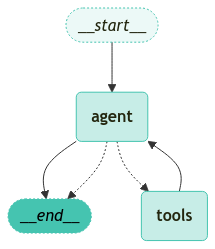

In [11]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(app)

실행하여 결과를 확인해보겠습니다.

In [12]:
# 실행 및 결과 확인
for chunk in app.stream(
    {"messages": [("human", "처음 5개의 소수를 출력하는 python code 를 작성해줘")]},
    stream_mode="values",
):
    # 마지막 메시지 출력
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

처음 5개의 소수를 출력하는 python code 를 작성해줘
================================== Ai Message ==================================
Tool Calls:
  python_code_interpreter (call_P1iDXFIuoFXpQ1rM3OgGNqfG)
 Call ID: call_P1iDXFIuoFXpQ1rM3OgGNqfG
  Args:
    code: def first_n_primes(n):
    primes = []
    num = 2  # Starting from the first prime number
    while len(primes) < n:
        is_prime = True
        for i in range(2, int(num**0.5) + 1):
            if num % i == 0:
                is_prime = False
                break
        if is_prime:
            primes.append(num)
        num += 1
    return primes

# Get the first 5 prime numbers
first_n_primes(5)
================================= Tool Message =================================
Name: python_code_interpreter

[2, 3, 5, 7, 11]
================================== Ai Message ==================================

처음 5개의 소수는 다음과 같습니다: [2, 3, 5, 7, 11]


In [13]:
# 검색 질문 수행
for chunk in app.stream(
    {"messages": [("human", "search google news about AI")]},
    stream_mode="values",
):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

search google news about AI
================================== Ai Message ==================================
Tool Calls:
  search_news (call_2qaqAB5rVbRvidWSBLbdaYSN)
 Call ID: call_2qaqAB5rVbRvidWSBLbdaYSN
  Args:
    query: AI
================================= Tool Message =================================
Name: search_news

[{"url": "https://news.google.com/rss/articles/CBMigwFBVV95cUxQUEVnS0U4OC1COVpZbE0wV1BJWlpKbWZtRnpDU1NybGk1Wi1JdS03ZTdnYjNNTXJhbk01alhVRV9HMlpCYjlLM09ubDN1NlBHYTltcW5QSVhiWHJVc2RmX1p6bC1YNC0zYzQyZ1pJclRydGY3WXVXLXVKd1NFWHFwSFEtMNIBlwFBVV95cUxQbmVUczhuQV9OT0pMbTllT0k5N1hsVWlHTUVjdFl3Y0ppZkJGNEdjZ0FOdEppcVRvYTZWZWU1czhhVmx5RU8yYktFekM1bE5yTDVsX3NTNkxKUXFsZFZ3dENuQnY5X2QzaFFUUGVtUmh5XzRPUUFYalgwN09WckxhekJVUEZFMnVPZngxSDBILUJkdGhiZGFZ?oc=5", "content": "AI가 소 키우니 “폐사 67% 줄어” - 조선일보"}, {"url": "https://news.google.com/rss/articles/CBMiTkFVX3lxTE5QR0tkd3llN2dMc09nWVpOMldTNG4zMWZTNWs5T1M3

In [14]:
# 도구 호출이 필요 없는 질문 수행
for chunk in app.stream(
    {"messages": [("human", "안녕? 반가워")]},
    stream_mode="values",
):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

안녕? 반가워
================================== Ai Message ==================================

안녕하세요! 반가워요. 어떻게 도와드릴까요?


`ToolNode`는 도구 실행 중 발생하는 오류도 처리할 수 있습니다. 

`handle_tool_errors=True`를 설정하여 이 기능을 활성화/비활성화할 수 있습니다(기본적으로 활성화되어 있음)